# 👩‍🏫 *MEGAN: Multi Explanation Graph Attention Network*

The `Megan` model is a *graph neural network (GNN)* architecture designed to be *self-explainable* - meaning that it should output not only the primary target property prediction but also an explanation of its own decision at the same time. The model does this by using an internal attention mechanism to identify the most relevant nodes and edges in the input graph which are provide evidence for or against the predicted property.

This following notebook demonstrates how to set up, train and predict with the `Megan` model, implemented in the `graph_attention_student`.

# Loading the Dataset

As a first step, we can load the dataset that will be used to demonstrate the model capabilities. 

In [2]:
import os
import csv
import pandas as pd

# --- loading the dataset ---

# This is the path to the folder in which this notebook is located in.
PATH: str = os.getcwd()
# For the purpose of this example, we use the dataset file "clogp.csv" that is located 
# in the same "examples" folder as this notebook.
DATASET_PATH: str = os.path.join(PATH, "clogp.csv")

# The example dataset is a CSV file consisting of molecular data in the format of 
# SMILES strings along with their corresponding clogP annotations. We can use 
# pandas, for example, to load this dataset.
dataset: pd.DataFrame = pd.read_csv(DATASET_PATH)

dataset.head()

,smiles,value
0,Cc1cccc(C=C)c1,2.63802
1,Cc1cc(cc(C)c1O)C(C)(C)c2cc(C)c(O)c(C)c2,4.65738
2,O=C1CCCCCCCCCOCCCCCO1,3.85090
3,CCCCCCCCCCC(C)CCCCCCCC,7.90390
4,NC(=O)N=NC(N)=O,-0.40400


# Dataset Processing

After loading the dataset in the previous step, the individual elements are still represented as SMILES strings. The `Megan` model, however, is a *graph neural network (GNN)* and thus requires a *graph representation* of these molecule. For this purpose we can use the `MoleculeProcessing` class from the `visual_graph_datasets` library, which converts the SMILES strings into appropriate graph representations.

More specifically, the `MoleculeProcessing` class provides the `process(smiles: str) -> dict` method which converts the SMILES string into a dictionary representation of the graph. This dictionary contains various numpy arrayes representing different aspects of the graph such as list of the atom and bond types, the connectivity of the graph in the form of an edge index list and the already featurized node and edge feature arrays.

In [3]:
from rich.pretty import pprint
from visual_graph_datasets.processing.molecules import MoleculeProcessing

# The SMILES representation of caffeine, which we want to use as an example for 
# the conversion into a graph representation.
SMILES = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'

processing = MoleculeProcessing()
graph: dict = processing.process(SMILES)

print('\n attributes of the graph dictionary:')
pprint(list(graph.keys()))
print('\n graph dictionary:')
pprint(graph)


 attributes of the graph dictionary:


[
│   'node_indices',
│   'node_attributes',
│   'edge_indices',
│   'edge_attributes',
│   'graph_attributes',
│   'graph_labels',
│   'graph_repr',
│   'node_atoms',
│   'edge_bonds'
]


 graph dictionary:


{
│   'node_indices': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
│   'node_attributes': array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
│      [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
│      [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
│      [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
│      [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
│      [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
│      [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
│      [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
│      [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
│      [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
│      [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
│      [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
│      [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
│      [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]),
│   'edge_indices': array([[ 0,  1],
│      [ 1,  0],
│      [ 1,  2],
│      [ 2,  1],
│      [ 2,  3],
│      [ 3,  2],
│      [ 3,  4],
│      [ 4,  3],
│      [ 4,  5],
│      [ 5,  4],
│      [ 5,  6],
│      [ 6,  5],
│      [ 6,  7],
│      [ 7,  6],
│      [ 6,  8],
│      [ 8,  6],
│      [ 8,  9],
│      [ 9,  8],
│      [ 9, 10],
│      [10,  9],
│      [ 9, 11],
│      [11,  9],
│      [11, 12],
│      [12, 11],
│      [ 8, 13],
│      [13,  8],
│      [ 5,  1],
│      [ 1,  5],
│      [11,  4],
│      [ 4, 11]]),
│   'edge_attributes': array([[1., 0., 0., 0.],
│      [1., 0., 0., 0.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 1., 0., 0.],
│      [0., 1., 0., 0.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 1., 0., 0.],
│      [0., 1., 0., 0.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [1., 0., 0., 0.],
│      [1., 0., 0., 0.],
│      [1., 0., 0., 0.],
│      [1., 0., 0., 0.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.],
│      [0., 0., 0., 1.]]),
│   'graph_attributes': array([194.08037556]),
│   'graph_labels': array([], dtype=float64),
│   'graph_repr': 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',
│   'node_atoms': array(['C', 'N', 'C', 'N', 'C', 'C', 'C', 'O', 'N', 'C', 'O', 'N', 'C',
│      'C'], dtype='<U1'),
│   'edge_bonds': array(['S', 'A', 'A', 'A', 'A', 'A', 'D', 'A', 'A', 'D', 'A', 'S', 'S',
│      'A', 'A'], dtype='<U1')
}

In addition to the conversion of a SMILES to a graph dictionary representation, the `MoleculeProcessing` class also provides the `visualize_as_figure(smiles: str) -> plt.Figure, ndarray` method which can be used to visualize the molecule as a 2D figure (using RDKit under the hood).

Crucially, this method returns a tuple of two values, the first being the matplotlib figure object and the second being an array of `node_positions` containing the 2D coordinates of each atom of the molecule in the coordinate system of the figure. This information is essential later on for the visualization of the node importance explanations provided by the `Megan` model.

/tmp/ipykernel_1989869/1307440298.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


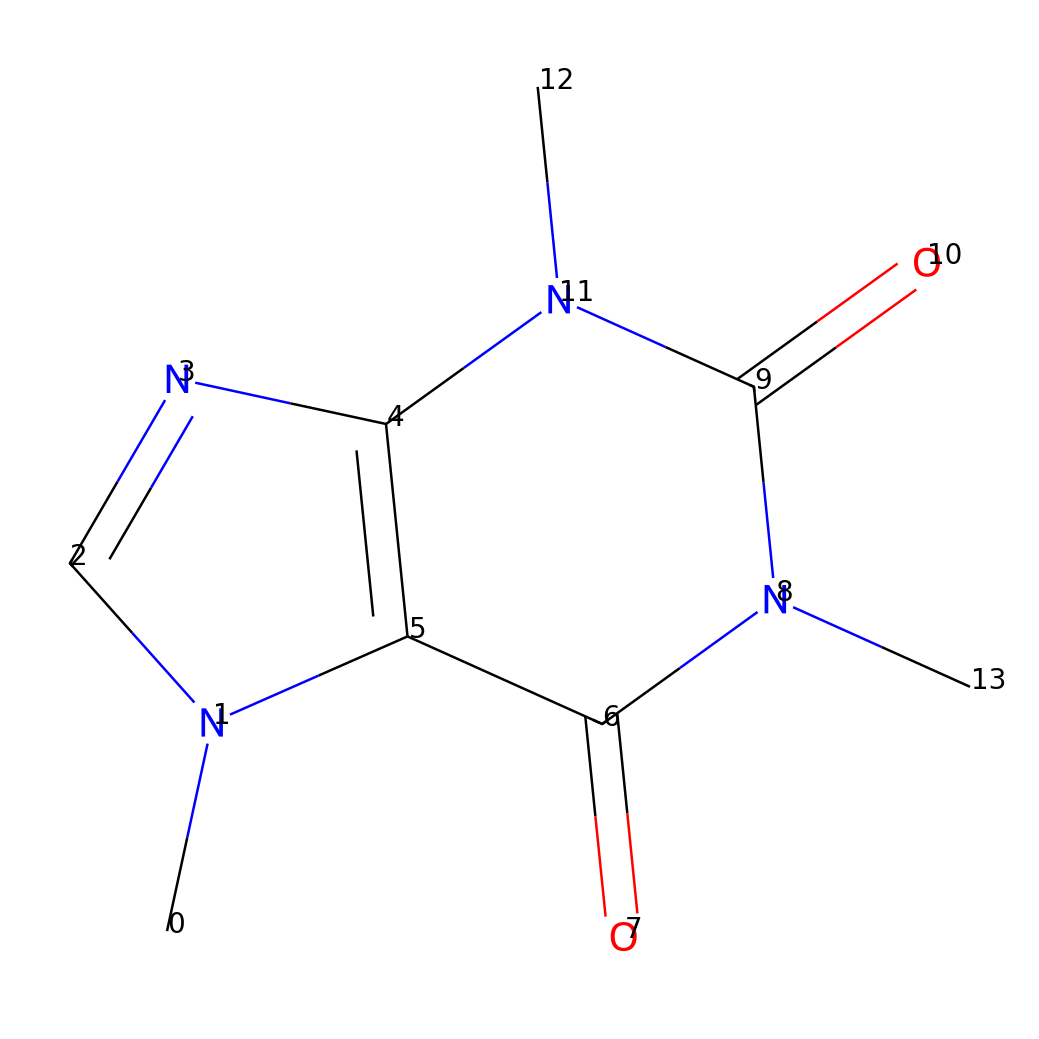

In [4]:
fig, node_positions = processing.visualize_as_figure(SMILES, width=1000, height=1000)

# To illustrate the the node positions, we will plot the node index of each atom on top 
# of the molecular illustration.
for node_idx, (x, y) in enumerate(node_positions):
    ax = fig.axes[0]
    ax.text(x, 1000-y, str(node_idx), fontsize=10, color='black')
    
fig.show()


# 🤖 Setting up the Model

In [5]:
from graph_attention_student import Megan

model = Megan(
    # --- prediction config ---
    # These first parameters need to specify how many node and edge features are used 
    # for the graphs that will be input to the model. This information can be obtained 
    # from the MoleculeProcessing object that was used to create the graphs.
    node_dim=processing.get_num_node_attributes(),
    edge_dim=processing.get_num_edge_attributes(),
    # This list determines the structure of the message passing layers in the encoder.
    # In this case we use three message passing steps with 64 hidden units each.
    units=[64, 64, 64], 
    # Likewise, this list determines the structure of the final prediction MLP. For 
    # this one, it is important that the last entry matches the number of target 
    # values to be predicted (i.e. 1 for regression, or the number of classes
    # for classification).
    final_units=[64, 32, 1],
    # This flag indicates that we want to perform a regression task. For binary 
    # classification this would be 'bce' and for multi-class classification
    # 'classification'.
    prediction_mode='regression',
    # The learning rate controls how large the steps are that are taken during
    # gradient descent optimization.
    learning_rate=1e-5,
    # --- explanation config ---
    # Following parameters determine the configuration of the explanation mechanism.
    importance_mode='regression',
    # Most importantly setting this importance factor to a non-zero value activates 
    # the explanation consistency co-training loss.
    importance_factor=1.0,
    # Likewise, this factor modulates the weight of the sparsity loss that is 
    # applied to the explanation masks during training.
    sparsity_factor=1.0,
    # This value also influences the sparsity of the resulting explanations. The higher 
    # this value, the more sparse the explanation will be (meaning that less nodes 
    # will be highlighted as important). Lower values will highlight more nodes.
    importance_offset=1.0,
    regression_margin=-0.2,
)

print('\n model summary:')
model


 model summary:


Megan(
  (lay_embedd): Linear(in_features=10, out_features=64, bias=True)
  (lay_transform_1): Linear(in_features=10, out_features=16, bias=True)
  (lay_transform_2): Linear(in_features=16, out_features=1, bias=False)
  (encoder_layers): ModuleList(
    (0-1): 2 x ParallelHeadAttention(
      (layers): ModuleList(
        (0-1): 2 x GraphAttentionLayerV2()
      )
      (lay_act): LeakyReLU(negative_slope=0.01)
    )
    (2): ParallelHeadAttention(
      (layers): ModuleList(
        (0-1): 2 x GraphAttentionLayerV2()
      )
      (lay_act): Identity()
    )
  )
  (lay_dropout_encoder): Dropout(p=0.0, inplace=False)
  (lay_pool): SumAggregation()
  (lay_pool_mean): MeanAggregation()
  (lay_pool_edge): MaxAggregation()
  (lay_pool_importance): SumAggregation()
  (importance_layers): ModuleList(
    (0): Linear(in_features=64, out_features=2, bias=True)
  )
  (channel_projection_layers): ModuleList(
    (0-1): 2 x ModuleList(
      (0): Sequential(
        (0): Linear(in_features=64, ou

# 🤖 Model Training

In [6]:
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader
from graph_attention_student import SmilesDataset


dataset = SmilesDataset(
    dataset=DATASET_PATH,
    smiles_column='smiles',
    target_columns=['value'],
    processing=processing,
)

loader_train = DataLoader(
    dataset, 
    batch_size=64, 
    #shuffle=True,
    drop_last=True,
    num_workers=4,
    prefetch_factor=2,
)

trainer = pl.Trainer(
    max_epochs=100,
    accelerator='auto',
    devices='auto',
)

/media/ssd/Programming/graph_attention_student/venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /media/ssd/Programming/graph_attention_student/venv/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/media/ssd/Programming/graph_attention_student/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one

In [7]:
trainer.fit(
    model,
    train_dataloaders=loader_train,
)

model.eval()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type               | Params | Mode 
--------------------------------------------------------------------------
0  | lay_embedd                | Linear             | 704    | train
1  | lay_transform_1           | Linear             | 176    | train
2  | lay_transform_2           | Linear             | 16     | train
3  | encoder_layers            | ModuleList         | 607 K  | train
4  | lay_dropout_encoder       | Dropout            | 0      | train
5  | lay_pool                  | SumAggregation     | 0      | train
6  | lay_pool_mean             | MeanAggregation    | 0      | train
7  | lay_pool_edge             | MaxAggregation     | 0      | train
8  | lay_pool_importance       | SumAggregation     | 0      | train
9  | importance_layers         | ModuleList         | 130    | train
10 | channel_projection_layers | ModuleList         | 8.6 K  | train
11 | dense_layers              | ModuleList         | 

Epoch 8: |          | 44/? [00:01<00:00, 29.27it/s, v_num=20, loss_pred=2.990, loss_expl=0.863, loss_spar=0.939, loss_cont=0.000, loss_fid=0.000] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# 💾 Saving and Loading the Model

In [8]:
MODEL_PATH = os.path.join(PATH, "model.ckpt")

model.save(MODEL_PATH)

model = Megan.load(MODEL_PATH)

# 🔮 Model Prediction

In [9]:
graph = processing.process(SMILES)

results: dict = model.forward_graph(graph)
print('\n prediction results:')
pprint(list(results.keys()))

print('\n predicted value:')
pprint(results['graph_output'].item())


 prediction results:


[
│   'graph_output',
│   'graph_embedding',
│   'node_embedding',
│   'node_importance',
│   'node_importance_norm',
│   'edge_importance',
│   'edge_importance_norm',
│   'graph_variance'
]


 predicted value:


0.03660273551940918

In [13]:
from IPython.display import IFrame
from graph_attention_student.torch.advanced import megan_prediction_report

output_path = os.path.join(PATH, "megan_prediction_report.pdf")
megan_prediction_report(
    value=SMILES,
    model=model,
    processing=processing,
    output_path=output_path,
)

IFrame(output_path, width=600, height=600)